In [1]:
from tools import obj_dic, show_heatmap, show_heatmap_contours

import jax
from jax import numpy as jnp, random
import numpy as _np # mostly for plotting
from scipy.stats import norm, invgamma, beta # mostly for plotting

from matplotlib import pyplot as plt
from IPython.display import display, Markdown

md = lambda *args: display(Markdown(*args))


In [2]:
r = random.PRNGKey(123456)
r, k = random.split(r, 2)

# Generate the Dataset as N draws from a normal distribution with base_mean and base_stdev

base_mean = 4
base_stdev = 1
N = 100
X = random.normal(k, (N, 1)) * base_stdev + base_mean


/home/twilight/VENV-MAIN/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


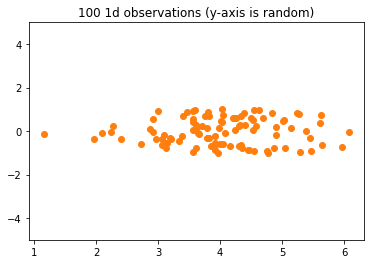

In [3]:
# Look at the data
plt.scatter([],[])
plt.scatter(X[:,0], _np.random.uniform(-1, 1, (N)))
plt.ylim(-5, 5)
plt.title(str(N)+" 1d observations (y-axis is random)")
plt.show()



In [4]:
# define a function to compute (on a grid, up to a constant factor) and draw the true posterior p(θ|X)

def plot_true_distribution(contours=True, cmap="gray",
                           minx=base_mean-0.3,
                           maxx=base_mean+0.3,
                           miny=base_stdev/1.3,
                           maxy=base_stdev*1.3,
                           prior=None):
    mm = lambda a: (_np.min(a), _np.max(a))
    Lprop = lambda μ, σ, X: 1/(2*_np.pi*σ**2)**(X.shape[0]/2) * _np.exp(- _np.sum((X - μ)**2, axis=0, keepdims=True) / (2*σ**2))
    linspaceμ = _np.linspace(minx, maxx, 101)
    linspaceσ = _np.linspace(miny, maxy, 103)
    Lmap = Lprop(linspaceμ[None,:,None], linspaceσ[None,None,:], X[:,None])
    if prior is not None:
        Lmap *= prior(linspaceμ[:,None], linspaceσ[None,:])
    if contours:
        plt.contour((Lmap[0].T), extent=[*mm(linspaceμ), *mm(linspaceσ)], origin='lower', cmap=cmap)
    else:
        plt.imshow((Lmap[0].T), extent=[*mm(linspaceμ), *mm(linspaceσ)], origin='lower', aspect='auto')
        plt.colorbar()
    return obj_dic(locals())


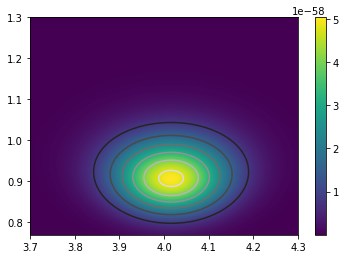

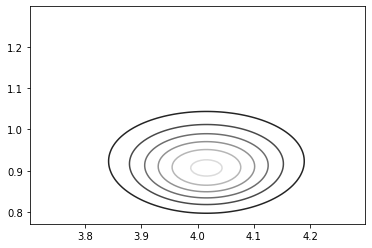

In [5]:
# Show the true posterior

default_plot = plot_true_distribution(False)
plot_true_distribution()
plt.show()
plot_true_distribution()
plt.show()



# GIBBS SAMPLING EXAMPLE

### Running the Gibbs sampler, showing the successive conditional probabilities

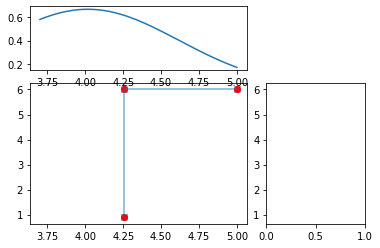

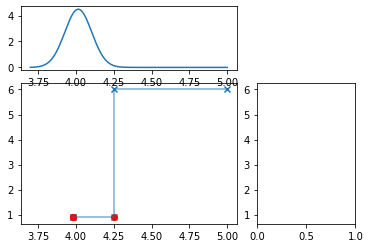

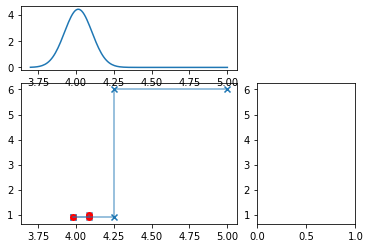

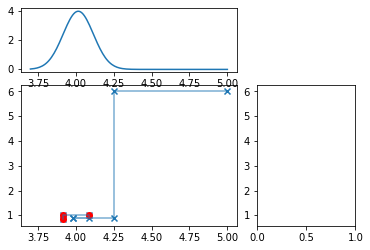

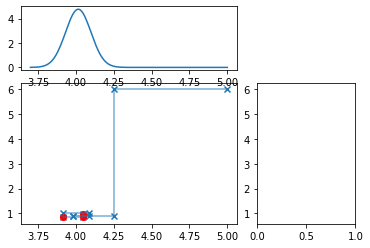

### Plotting after 100 samples

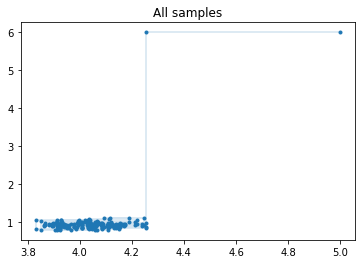

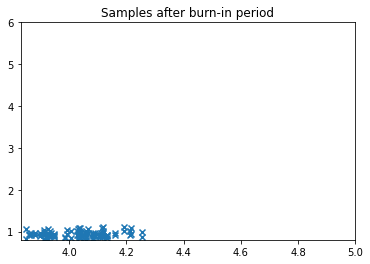

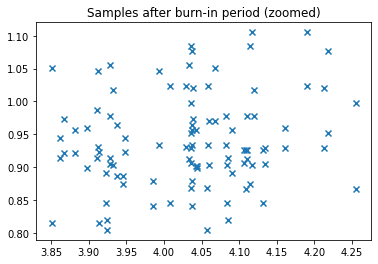

Estimating the p(θ|X) as an histogram from samples (true posterior with lines)

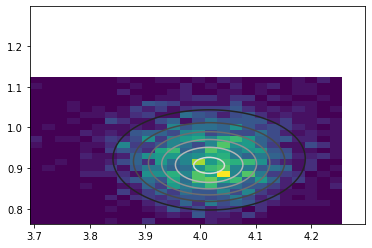

CPU times: user 3.84 s, sys: 358 ms, total: 4.2 s
Wall time: 3.68 s


In [6]:
%%time

md("# GIBBS SAMPLING EXAMPLE")

def do_gibbs_uninformative_prior(r, X = jnp.array(X)):
    μ = 5  ####### GIBBS: initialize
    σ = 6  ####### GIBBS: initialize
    
    μs = [μ]
    σs = [σ]

    ITER = 20000//10
    BURN = 100
    PLOT_AT = [200 // 2]
    PLOT_NICE_AT = [0, 1, 2, 3, 4]
    md('### Running the Gibbs sampler, showing the successive conditional probabilities')
    for i in range(ITER//2):  ####### GIBBS: loop
        
        # scipy normal distribution uses the standard deviation
        r, k = random.split(r, 2)
        μ = random.normal(k)*σ/N**0.5 + jnp.mean(X)  ####### GIBBS: one step
        μs.append(μ)
        σs.append(σ)

        r, k = random.split(r, 2)
        invσ = random.gamma(k, N/2 - 1) / (jnp.sum((X-μ)**2)/2)
        σ = 1 / invσ ** 0.5 ####### GIBBS: another step
        #σ = invgamma.rvs(N/2 - 1, 0, np.sum((X-μ)**2)/2) ** 0.5  
        μs.append(μ)
        σs.append(σ)
        
        if i in PLOT_NICE_AT:
            minx = min(base_mean-0.3, _np.min(μs))
            maxx = max(base_mean+0.3, _np.max(μs))
            miny = min(base_stdev/1.3, _np.min(σs))
            maxy = max(base_stdev*1.3, _np.max(σs))
            ax = plt.subplot(3, 3, (4,8))
            plt.plot(μs, σs, alpha=0.6)
            plt.scatter(μs, σs, marker='x')
            
            plt.subplot(3, 3, (1,2), sharex=ax)
            x = _np.linspace(minx, maxx, 151)
            plt.plot(x, jax.scipy.stats.norm.pdf(x, _np.mean(X), σs[-3] / N**0.5))

            plt.subplot(3, 3, (6,9), sharey=ax)
            x = _np.linspace(miny, maxy, 151)
            #plt.plot(invgamma.pdf(x**2, N/2 - 1, 0, _np.sum((X-μs[-2])**2)/2), x)

            ax.scatter(μs[-3:], σs[-3:], c='r')
            plt.show()
        if i in PLOT_AT:
            md('### Plotting after '+str(i)+' samples')
            plt.plot(μs, σs, alpha=0.2)
            plt.scatter(μs, σs, marker='.')
            plt.title('All samples')
            plt.show()

            plt.scatter(μs[BURN:], σs[BURN:], marker='x')
            plt.xlim(_np.min(μs), _np.max(μs))
            plt.ylim(_np.min(σs), _np.max(σs))
            plt.title('Samples after burn-in period')
            plt.show()
            
            plt.scatter(μs[BURN:], σs[BURN:], marker='x')
            plt.title('Samples after burn-in period (zoomed)')
            plt.show()


    md('Estimating the p(θ|X) as an histogram from samples (true posterior with lines)')
    show_heatmap(μs[BURN:], σs[BURN:], bins=25)
    plot_true_distribution()
    plt.show()
    return obj_dic(locals())

gibbs = do_gibbs_uninformative_prior(r)


# GIBBS SAMPLING EXAMPLE (plot at end only)

### Running the Gibbs sampler

Estimating the p(θ|X) as an histogram from samples (true posterior with lines)

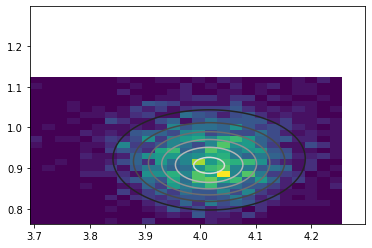

CPU times: user 2.02 s, sys: 313 ms, total: 2.34 s
Wall time: 1.83 s


In [7]:
%%time

md("# GIBBS SAMPLING EXAMPLE (plot at end only)")

def do_gibbs_uninformative_prior_simpler(r, X = jnp.array(X)):
    μ = 5  ####### GIBBS: initialize
    σ = 6  ####### GIBBS: initialize
    
    μs = [μ]
    σs = [σ]

    ITER = 20000//10
    BURN = 100
    md('### Running the Gibbs sampler')
    for i in range(ITER//2):  ####### GIBBS: loop
        
        # scipy normal distribution uses the standard deviation
        r, k = random.split(r, 2)
        μ = random.normal(k)*σ/N**0.5 + jnp.mean(X)  ####### GIBBS: one step
        μs.append(μ)
        σs.append(σ)

        r, k = random.split(r, 2)
        invσ = random.gamma(k, N/2 - 1) / (jnp.sum((X-μ)**2)/2)
        σ = 1 / invσ ** 0.5 ####### GIBBS: another step
        #σ = invgamma.rvs(N/2 - 1, 0, np.sum((X-μ)**2)/2) ** 0.5  
        μs.append(μ)
        σs.append(σ)

    md('Estimating the p(θ|X) as an histogram from samples (true posterior with lines)')
    show_heatmap(μs[BURN:], σs[BURN:], bins=25)
    plot_true_distribution()
    plt.show()
    return obj_dic(locals())

gibbs = do_gibbs_uninformative_prior_simpler(r)


# GIBBS SAMPLING EXAMPLE (fast with a lax.scan)

### Running the Gibbs sampler

OK (DeviceArray(3.9807317, dtype=float32), DeviceArray(0.8311278, dtype=float32), DeviceArray([3070055650, 1116728213], dtype=uint32))
H [DeviceArray([4.5777807, 4.241786 , 4.163815 , ..., 4.1279035, 4.0552154,
             3.9807317], dtype=float32), DeviceArray([4.5777807, 4.241786 , 4.163815 , ..., 4.1279035, 4.0552154,
             3.9807317], dtype=float32), DeviceArray([6.       , 1.0302258, 1.0810943, ..., 0.8151014, 0.9116325,
             0.8884005], dtype=float32), DeviceArray([1.0302258, 1.0810943, 0.7993626, ..., 0.9116325, 0.8884005,
             0.8311278], dtype=float32)]
Estimating the p(θ|X) as an histogram from samples (true posterior with lines)


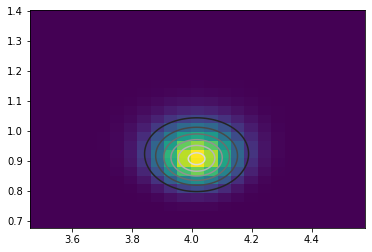

CPU times: user 3.49 s, sys: 104 ms, total: 3.59 s
Wall time: 3.61 s


In [8]:
%%time
## NB: much more iterations, way faster
## NB: with 20000*100, the numpy version takes around 88sec
## NB: with 20000*1 , the bad jax version takes 17sec so 1700sec in comparison
## NB: on the same machine, no GPU, this jax.lax.scan version takes around 3.8sec (20× speedup)

md("# GIBBS SAMPLING EXAMPLE (fast with a lax.scan)")

def do_gibbs_uninformative_prior_scan(r, X = jnp.array(X)):
    μ = 5  ####### GIBBS: initialize
    σ = 6  ####### GIBBS: initialize
        
    def scanner(μ_σ_r, i):
        μ, σ, r = μ_σ_r
        r, *k = random.split(r, 3)
        μ1 = random.normal(k[0])*σ/N**0.5 + jnp.mean(X)  ####### GIBBS: one step
        invσ2 = random.gamma(k[1], N/2 - 1) / (jnp.sum((X-μ1)**2)/2)
        σ2 = 1 / invσ2 ** 0.5 ####### GIBBS: another step
        return (μ1, σ2, r), [μ1, μ1, σ, σ2]


    ITER = 20000*100
    BURN = 100
    
    md('### Running the Gibbs sampler')
    μ_σ_r, history = jax.lax.scan(scanner, (μ, σ, r), jnp.arange(ITER))
    print("OK", μ_σ_r)
    print("H", history)
    
    μs = [v for l in history[:2] for v in l]
    σs = [v for l in history[2:] for v in l] 

    print('Estimating the p(θ|X) as an histogram from samples (true posterior with lines)')
    show_heatmap(μs[BURN:], σs[BURN:], bins=25)
    plot_true_distribution()
    plt.show()
    return obj_dic(locals())

gibbs = do_gibbs_uninformative_prior_scan(r)

## TODO show trajectories (also in the numpy version)


# METROPOLIS-HASTINGS EXAMPLE

## Showing accepted samples and rejected samples (1 chain)

### No prior

... Running the MH sampler

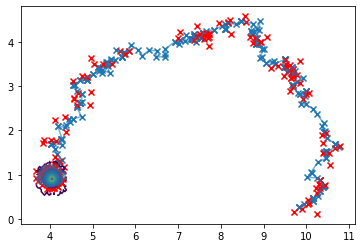

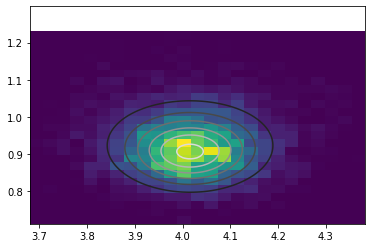

Accepted 8967 and rejected 11033

### Prior that biases the estimate

... Running the MH sampler

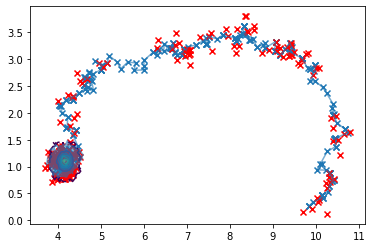

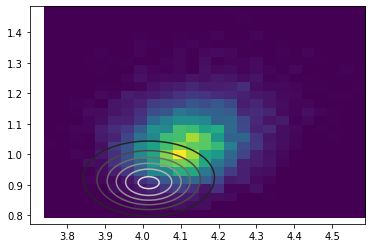

Accepted 10283 and rejected 9717

### Prior that forbids σ > 2.5

... Running the MH sampler

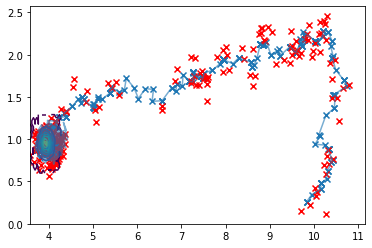

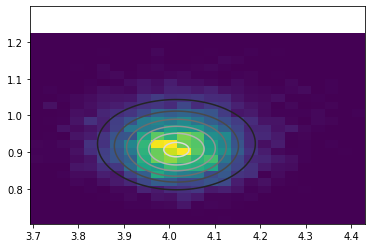

Accepted 8893 and rejected 11107

## Draw a few chains

Prior: False

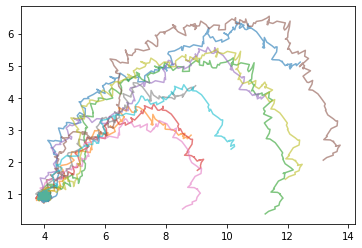

Prior: True

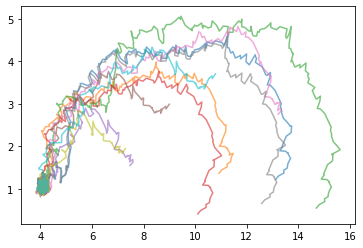

Prior: Funky

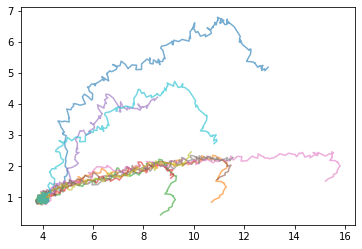

CPU times: user 14.4 s, sys: 47.8 ms, total: 14.5 s
Wall time: 14.5 s


In [9]:
%%time
md('# METROPOLIS-HASTINGS EXAMPLE')

def do_metropolis_hastings(prior=False, show=True, ITER=20000*1, INIT=(10,0.1), md=md):
    μ, σ = INIT ####### METROPOLIS-HASTINGS: initialize

    xsh0 = X.shape[0]
    lnLproportional = jax.jit(lambda μ, σ: -(xsh0*jnp.log(σ) + jnp.sum((X - μ)**2)/2/σ**2)) # up to log((2π)^½N)
        
    if prior == 'Funky':
        lnprior = jax.jit(lambda μ, σ: 100*jnp.log(jnp.clip(2.5 - σ, 0.0001, 1)))
    elif prior:
        lnprior = lambda μ, σ: -(μ-5)**2/.2 + -(σ-3)**2/.2  # kind of gaussian prior around μ=5, σ=2, pretty tight, so we see that even with 100 observations the prior impacts significantly what is the optimal p(μ,σ|X)
    else:
        lnprior = lambda *a:0 # uninformative prior, or very very broad/smooth
        
    BURN = 1000
    μσvar = .1

    def scanner(μ_σ_r, i):
        μ, σ, r = μ_σ_r
        r, *k = random.split(r, 4)
        
        μnew = random.normal(k[0])*μσvar + μ
        σnew = random.normal(k[1])*μσvar + σ
        
        paccept = jnp.exp(
            lnLproportional(μnew, σnew) - lnLproportional(μ, σ)
            + lnprior(μnew, σnew) - lnprior(μ, σ) # prior
        ) ####### METROPOLIS-HASTINGS: compute acceptance "probability" (might be > 1)
        
        a = random.uniform(k[2]) < paccept
        μ = jnp.where(a, μnew, μ)
        σ = jnp.where(a, σnew, σ)
        return (μ, σ, r), [μ, σ, μnew, σnew, a]
    
    
    md('... Running the MH sampler')
    μ_σ_r, history = jax.lax.scan(scanner, (μ, σ, r), jnp.arange(ITER))
    #print("OK", μ_σ_r)
    #print("H", history)

    history = _np.array(history)
    μs = history[0]
    σs = history[1]
    rej_μs = [history[2,i] for i in range(history.shape[1]) if not history[4,i]]
    rej_σs = [history[3,i] for i in range(history.shape[1]) if not history[4,i]]

    plt.plot(μs, σs, alpha=0.6)
    if show:
        plt.scatter(μs[:400], σs[:400], marker='x')
        plt.scatter(history[2, :400][history[4, :400]==False], history[3, :400][history[4, :400]==False], marker='x', c='r')
        show_heatmap_contours(norm.rvs(μs[-1], μσvar, 10000), norm.rvs(σs[-1], μσvar, 10000))
        plt.show()

    if show:
        show_heatmap(μs[BURN:], σs[BURN:], bins=25)
        plot_true_distribution()
        plt.show()
    md("Accepted " + str(len(μs)-len(rej_μs)) + " and rejected " + str(len(rej_μs)))
    return obj_dic(locals())


md("## Showing accepted samples and rejected samples (1 chain)")
md("### No prior")
mh = do_metropolis_hastings()
md("### Prior that biases the estimate")
mh = do_metropolis_hastings(True)
md("### Prior that forbids σ > 2.5")
mh = do_metropolis_hastings("Funky")


md("## Draw a few chains")
for setup in [False, True, 'Funky']:
    md('Prior: '+str(setup))
    for i in range(10):
        do_metropolis_hastings(setup, show=False, ITER=500, INIT=(norm.rvs(10, 2), _np.abs(norm.rvs(1, 2))), md=lambda *a:0)
    plt.show()


# VARIATIONAL INFERENCE EXAMPLE

## Not too bad prior and initialization

... Running the VI loop

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

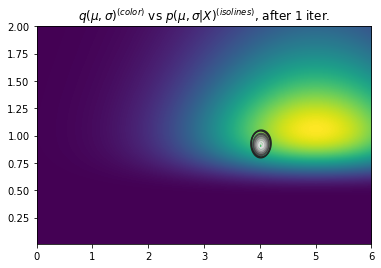

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

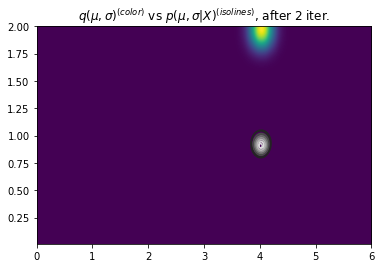

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

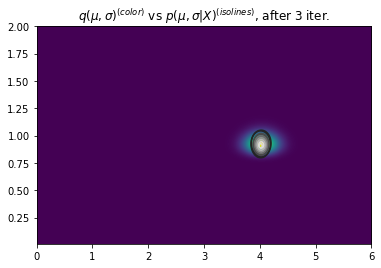

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

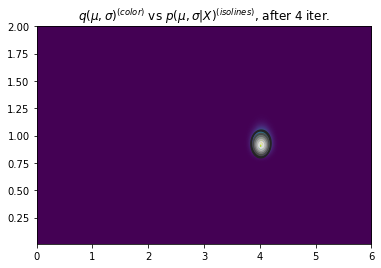

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

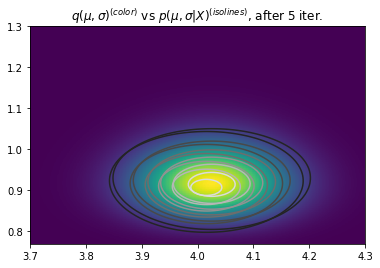

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

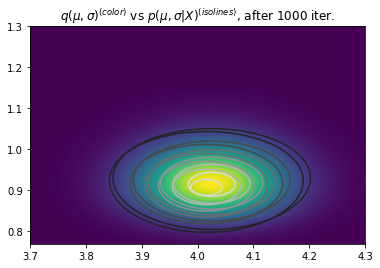

Plotting the mean of the estimate accross iterations (we see a convergence)

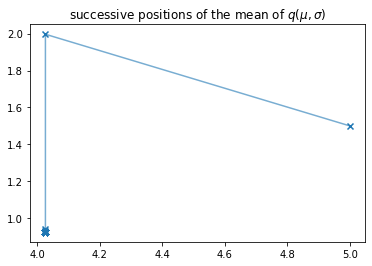

## Poor prior and initialization

... Running the VI loop

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

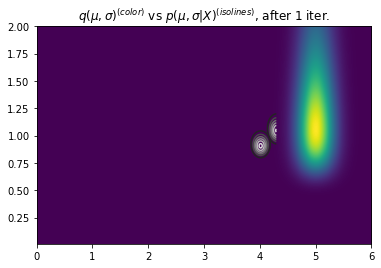

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

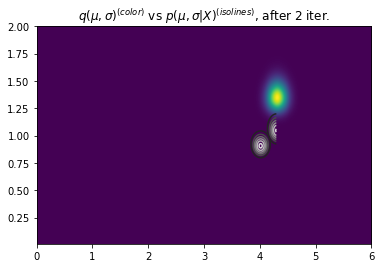

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

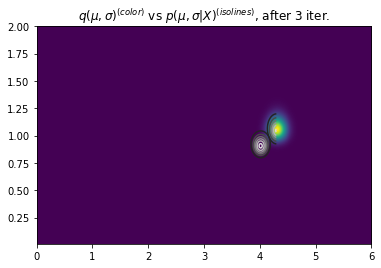

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

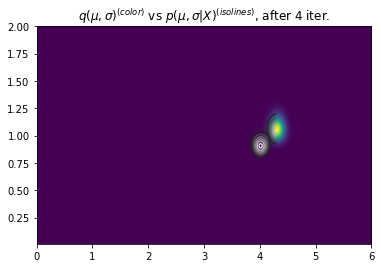

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

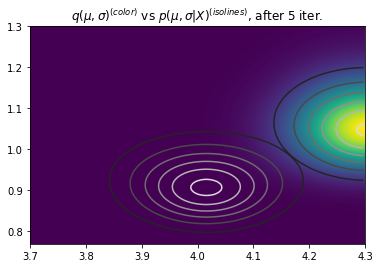

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

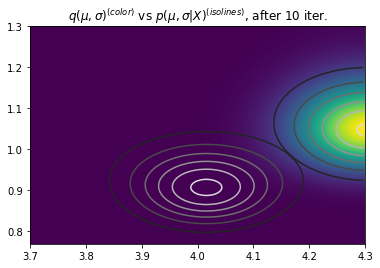

Plotting the mean of the estimate accross iterations (we see a convergence)

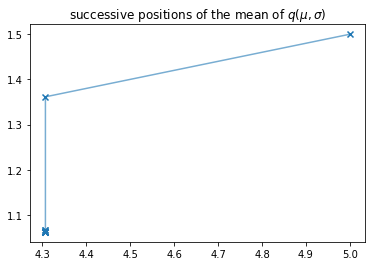

## Fuzzy prior and initialization

... Running the VI loop

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

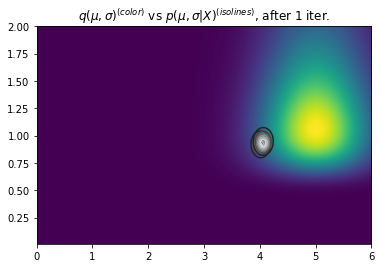

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

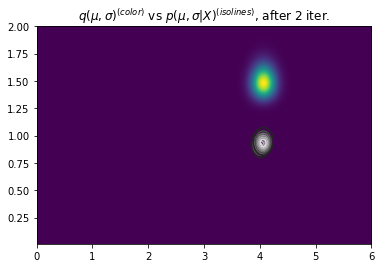

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

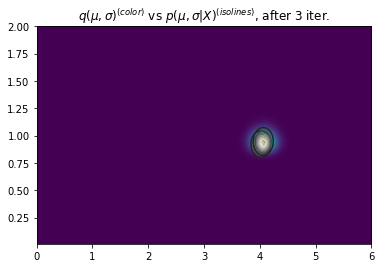

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

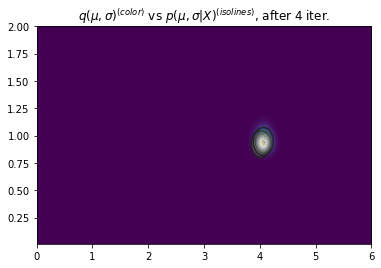

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

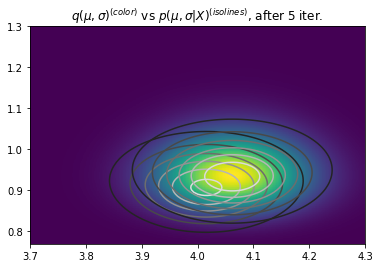

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

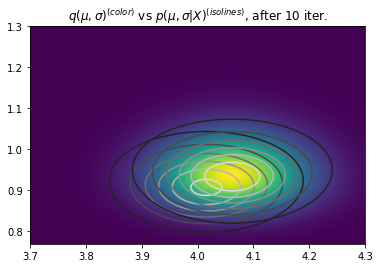

Plotting the mean of the estimate accross iterations (we see a convergence)

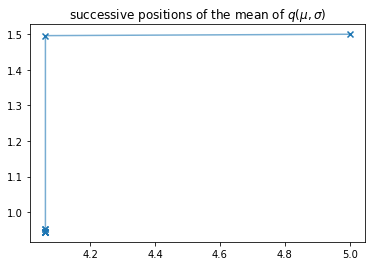

CPU times: user 3.16 s, sys: 79.4 ms, total: 3.24 s
Wall time: 3.21 s


In [10]:
%%time

md('# VARIATIONAL INFERENCE EXAMPLE')

def do_variational_inference(PRIOR=(5,1 , 1,1.5**2), ITER=1000):
    # we clearly don't need 1000 iterations but they are so cheap... (no sampling => very fast)
    
    µ0, λ0, α0, β0 = PRIOR ####### VARIATIONAL INFERENCE: prior
    
    ####### VARIATIONAL INFERENCE:  set inital values of the variational parameters using the prior
    μN = µ0
    σN = (β0/α0/λ0)**0.5
    αN = α0
    βN = β0
    toADD = (μN, σN, αN, βN)

    PLOT_AT = [ITER-1]
    PLOT_PDF_AT = [0, 1, 2, 3, 4, ITER-1]
    PLOT_BROAD =  [0, 1, 2, 3]

    ####### VARIATIONAL INFERENCE: constants
    Xsum = jnp.sum(X)
    X2sum = jnp.sum(X**2)

    def scanner(varpar, i):
        μN, σN, αN, βN = varpar
        αN,βN,μN,σN = (
            α0 + (N+1)/2,
            β0 + 0.5 * ( (λ0+N)*(σN**2+μN**2) - 2*(μ0*λ0+Xsum)*μN + X2sum + λ0*μ0**2 ),
            (Xsum + λ0*μ0) / (N + λ0),
            (βN/αN/(N+λ0))**0.5,
        )
        return (μN, σN, αN, βN), [μN, σN, αN, βN]
    
    
    md('... Running the VI loop')
    (μN, σN, αN, βN), history = jax.lax.scan(scanner, (μN, σN, αN, βN), jnp.arange(ITER))
    #print("OK", μ_σ_r)
    #print("H", history)

    history = _np.concatenate((_np.array([toADD]), _np.array(history).T), axis=0)

    for i in sorted(list(set(PLOT_AT + PLOT_PDF_AT))):
        μN,σN,αN,βN = history[i]
        if i in PLOT_PDF_AT:
            md('Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)')
            linspaceμ = default_plot.linspaceμ
            linspaceσ = default_plot.linspaceσ
            if i in PLOT_BROAD:
                linspaceμ = _np.linspace(0, 6, 303)
                linspaceσ = _np.linspace(0.01, 2, 301)
            pσ = invgamma.pdf(linspaceσ**2, αN, 0, βN)
            pμ = norm.pdf(linspaceμ[:,None], μN, σN)
            pμσ = pμ*pσ[None,:]

            mm = default_plot.mm
            plt.imshow(pμσ.T, extent=[*mm(linspaceμ), *mm(linspaceσ)], origin='lower', aspect='auto')
            #plt.colorbar()
            plot_true_distribution()
            plot_true_distribution(prior=lambda μ,σ: invgamma.pdf(σ**2, α0, 0, β0) * norm.pdf(μ, μ0, σ/λ0**0.5))
            plt.title("$q(\\mu, \\sigma)^{(color)}$ vs $p(\\mu, \\sigma | X)^{(isolines)}$, after "+str(i+1)+" iter.")
            plt.show()
 
        if i in PLOT_AT:
            md('Plotting the mean of the estimate accross iterations (we see a convergence)')
            h = _np.array(history)
            μs = h[:,0]
            σs = (h[:,3]/h[:,2])**0.5
            plt.title("successive positions of the mean of $q(\\mu, \\sigma)$")
            plt.plot(μs, σs, alpha=0.6)
            plt.scatter(μs, σs, marker='x')
            plt.show()

    return obj_dic(locals())

md('## Not too bad prior and initialization')
vi = do_variational_inference()
md('## Poor prior and initialization')
# 42 virtual points at value 5, 
vi = do_variational_inference(PRIOR=(5,42 , 1,1.5**2), ITER=10)
md('## Fuzzy prior and initialization')
# 5 points at 5
vi = do_variational_inference(PRIOR=(5,5 , 1,1.5**2), ITER=10)